###### Felipe BUZATO FRANÇA COSTA
###### MAP552 - $École Polytechnique$

In [90]:
# Libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
sns.set_style('darkgrid')

In [84]:
# Loading extra files 
Strikes = np.loadtxt('Strikes_CPS8.txt')
Maturities = np.loadtxt('Maturities_CPS8.txt') 
Prices = np.loadtxt('Prices_CPS8_v2.txt')
Prices.shape, Maturities.shape

((401, 257), (257,))

## CPS 3.2 - Local volatility and the Dupire formula

$\textit{The present problem set is attached to Chapter $10$ of the lectures notes. We denote by $C(T,K)$ the time 0-price of a European call option with maturity $T$ and strike $K$. We shall denote $C_T$ , $C_K$ and $C_{KK}$ the corresponding partial derivative with respect to $T$, with respect to $K$, and second partial derivative with respect to $K$, respectively. We recall the Dupire formula:}$

\begin{equation*}
    \sigma^2(T,K) = 2\frac{C_T (T,K) + rKC_K (T,K)}{K^2 C_{KK} (T,K)},
\end{equation*}

$\textit{In terms of the implied volatilities $I(T,K)$, obtained by inversion of the Black-Scholes formula $C^{BS}$, i.e. $C(T;K) = C^{BS}(T,K,I(T,K))$, this formula reduces to:}$

\begin{equation*}
     \sigma^2 (T,K) = \frac{\frac{I}{T} + 2I_T + 2rKI_K}{K^2 (\frac{1}{K^2 IT} + 2\frac{d_{+}}{KI\sqrt{T}}I_K + \frac{d_{+} d_{-}}{I} {I_{K}}^{2} + I_{KK})}    ,
\end{equation*}

where $d_{+}$ is the standard function involved in the Black-Scholes formula, and subscripts indicate again partial derivatives. 

The file optionprices.txt contains call options prices $C(T_i,K_j)$ for a spot price $S_0 = 100$, spot interest rate $r = 0$, maturities $T_i := i \frac{T}{n}$, $n = 8$, $T = 0.9$, $i = 0, . . . , n$, and strikes $K_j := 80 + 0.1 j$, $j = 0, . . . ,400$.

$\qquad 1.$ Provide an approximation $\overline{\sigma}^2 (T_i,K_j)$ of the Dupire local volatility function by using the Dupire formula $(1)$. Comment on the encountered numerical difficulties, if any.

In [85]:
# Function that returns a matrix containing the derivatives wrt time to maturity. 
def derivative_T_(prices, maturities):
    delta_T = maturities[0] - maturities[1]
    
    # Matrix that will contain in each row the derivatives wrt maturity for each time-step, for a determined strike K:
    derivative_T = np.zeros((prices.shape[0], prices.shape[1]-1))
        
    for i in range(derivative_T.shape[1]):        
        derivative_T[:,i] = (prices[:,i+1] - prices[:,i])/delta_T
        
    return derivative_T

# Function that returns a matrix containing the derivatives wrt time the strike prices. 
def derivative_K_(prices, strikes):
    delta_K = strikes[0] - strikes[1]
    
    # Matrix that will contain in each row the derivatives wrt strike price for each strike-step, for a determined time T:
    derivative_K = np.zeros((prices.shape[0]-1, prices.shape[1]))
        
    for i in range(derivative_K.shape[0]):        
        derivative_K[i,:] = (prices[i+1,:] - prices[i,:])/delta_K
        
    return derivative_K

# Function that returns a matrix containing the second derivatives wrt time the strike prices. 
def derivative_KK_(prices, strikes):
    delta_K = strikes[0] - strikes[1]
    
    # Matrix that will contain in each row the second-derivatives wrt strike price for each strike-step, for a determined time T:
    derivative_KK = np.zeros((prices.shape[0]-2, prices.shape[1]))
        
    for i in range(derivative_KK.shape[0]):        
        derivative_KK[i,:] = (prices[i,:] + prices[i+2,:] - 2*prices[i+1,:])/delta_K
        
    return derivative_KK

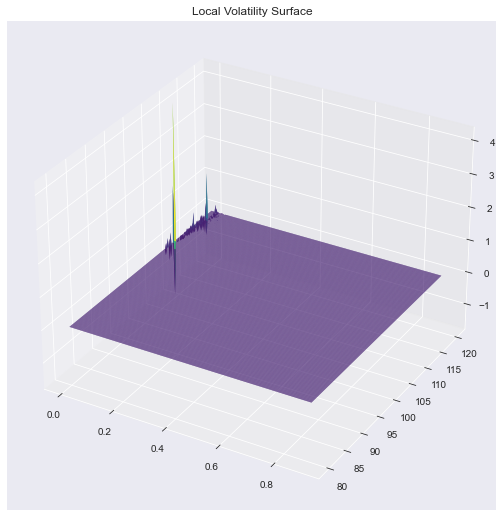

In [89]:
# Derivatives calculating by discretizing each time-step
derivative_T = derivative_T_(Prices, Maturities)
derivative_K = derivative_K_(Prices, Strikes)
derivative_KK = derivative_K_(derivative_K, Strikes)
#derivative_KK = derivative_KK_(Prices, Strikes)

# Reducing the size of the matrices, to assure that they have the same dimensions
# Loss due to the discretization
#derivative_T = derivative_T[1:derivative_T.shape[0]-1, :]
#derivative_KK = derivative_KK[:, :derivative_KK.shape[1]-1]
derivative_T = derivative_T[:derivative_T.shape[0]-2, :]
derivative_KK = derivative_KK[:, :derivative_KK.shape[1]-1]

# Dupire Formula
Local_Vol = np.zeros((derivative_T.shape[0], derivative_T.shape[1]))
for i in range(Local_Vol.shape[0]):
    for j in range(Local_Vol.shape[1]):
        if derivative_KK[i,j] != 0:
            Local_Vol[i,j] = (2/(Strikes[i]**2))*(derivative_T[i,j]/derivative_KK[i,j])
            #Local_Vol[i,j] = np.sqrt(Local_Vol[i,j])

# Plotting the local volatility calculated
X, Y = np.meshgrid(Maturities[:Maturities.shape[0]-1], Strikes[:Strikes.shape[0]-2])

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Local_Vol, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Local Volatility Surface');
plt.show()

As we can see in the plot, the result is not at all satisfactory. Many points of the Local Volatility's array are $0$ or really large numbers. That happens because, by discretizing the calcul of the second derivative the way it was done ($\frac{u(k+h)-u(k)}{h}$, where $u(k)$ is the derivative wrt the strike price at strike $k$), the second derivative $C_{KK}$ gets very often null values (or at least very close to zero). As a consequence, the estimate for the implied volatility explodes in many points. Errors in the market price data could potentially cause these problems.

$\qquad 2.$ We next turn to an alternative approximation method of the Dupire local volatility function.

$\qquad$ a) Deduce from the provided data the corresponding implied volatilities $I(T_i,K_j), i = 0, . . . , n$ and $j = 0, . . . , 400$.

- Newton - Raphson doesn't work because VEGA approx zero for 80 and 120.
- Bisection Method.
- Not consider maturity=0.

In [202]:
def Black_Scholes_(S0, T, K, sigma):
    d_plus = np.log(S0/K)/(np.sqrt(T)*sigma) + (1/2)*np.sqrt(T)*sigma
    d_moins = np.log(S0/K)/(np.sqrt(T)*sigma) - (1/2)*np.sqrt(T)*sigma
    return S0*norm.cdf(d_plus) - K*norm.cdf(d_moins)

def Vega_(S0, T, K, sigma):
    d_plus = np.log(S0/K)/(np.sqrt(T)*sigma) + (1/2)*np.sqrt(T)*sigma
    Vega = S0*np.sqrt(T)*np.exp((-1/2)*d_plus**2)/np.sqrt(2*np.pi)
    return Vega 

def Newton_Raphson_(i, j, prices, maturities, strikes):
    # Initialization
    initial_guess = 1/2 #np.sqrt(2*np.abs(np.log(100/strikes[i]))/maturities[j])
    Market_price = prices[i,j]
    BS_price = Black_Scholes_(100, maturities[j], strikes[i], initial_guess)
    Vega = Vega_(100, maturities[j], strikes[i], initial_guess)
    new_guess = initial_guess + (Market_price - BS_price)/Vega
    
    # Iterate untill convergence
    #while(np.abs(new_guess - initial_guess) > 0.001): 
    for iterate in range(10):
        initial_guess = new_guess
        BS_price = Black_Scholes_(100, maturities[j], strikes[i], initial_guess)
        Vega = Vega_(100, maturities[j], strikes[i], initial_guess)
        if Vega == 0:
            break
        new_guess = initial_guess + (Market_price - BS_price)/Vega
    
    return new_guess

def Bisection_(i, j, prices, maturities, strikes):
    # Initialization
    lower_initial_guess = 0
    higher_initial_guess = 20
    Market_price = prices[i,j]
    BS_price_higher = Black_Scholes_(100, maturities[j], strikes[i], higher_initial_guess)
    BS_price_lower = Black_Scholes_(100, maturities[j], strikes[i], lower_initial_guess)
    new_guess = lower_initial_guess + (Market_price - BS_price_lower)*(higher_initial_guess-lower_initial_guess)/(BS_price_higher - BS_price_lower)
    
    # Iterate untill convergence
    for iterate in range(20):
    #while(np.abs(higher_initial_guess-lower_initial_guess) > 0.01): 
        if Black_Scholes_(100, maturities[j], strikes[i], new_guess) < Market_price:
            lower_initial_guess = new_guess
            BS_price_lower = Black_Scholes_(100, maturities[j], strikes[i], lower_initial_guess)
        else:
            higher_initial_guess = new_guess
            BS_price_higher = Black_Scholes_(100, maturities[j], strikes[i], higher_initial_guess) 
        new_guess = lower_initial_guess + (Market_price - BS_price_lower)*(higher_initial_guess-lower_initial_guess)/(BS_price_higher - BS_price_lower)
    
    return new_guess

def Implied_Vol_(prices, maturities, strikes): 
    # Matrix that will contain in each element (i,j) the implied volatility for (Ti,Kj):
    Implied_Vol = np.zeros((prices.shape[0], prices.shape[1]-1))
    
    for i in range(Implied_Vol.shape[0]):
        for j in range(Implied_Vol.shape[1]):
            # Newton_Raphson's algorithm to estimate implied volatility
            Implied_Vol[i,j] = Newton_Raphson_(i, j+1, prices, maturities, strikes)
            if Implied_Vol[i,j] > 10 or Implied_Vol[i,j] < 0:
                Implied_Vol[i,j] = 0
         
    return Implied_Vol

<ipython-input-202-1d739e1ec425>:8: RuntimeWarning: overflow encountered in double_scalars
  Vega = S0*np.sqrt(T)*np.exp((-1/2)*d_plus**2)/np.sqrt(2*np.pi)
<ipython-input-202-1d739e1ec425>:27: RuntimeWarning: overflow encountered in double_scalars
  new_guess = initial_guess + (Market_price - BS_price)/Vega


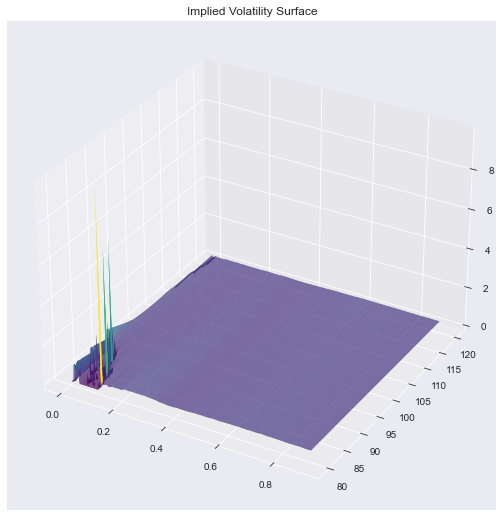

In [203]:
# Implied Volatility
Implied_Vol = Implied_Vol_(Prices, Maturities, Strikes)

# Plotting the Implied Volatility
X, Y = np.meshgrid(Maturities[1:], Strikes)

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Implied_Vol, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Implied Volatility Surface');
plt.show()

$\qquad 3.$ Using the parameters values $S_0 = 100, T = 2, \sigma_0 = 0.2, \lambda = 2, c = 0.4, \gamma = 0.3$ and $r = 0.02$, provide $M = 1000$ copies of an appropriate discretization of $P\&L_T (\Sigma)$ for $\Sigma = \sigma_0$, $K \in \{50 + j; j = 5, . . . , 150\}$, and $n \in \{50, 60, . . . , 100\}$. Compute the corresponding sample mean and variance.

In [ ]:
# Auxiliary function to calculate gamma at a certain price and time
def Gamma(S_t, K, t, Sigma, T, r):
    
    K_actual = K*np.exp(-r*(T-t))
    d_plus = np.log(S_t/K_actual)/np.sqrt(T*Sigma**2) + (1/2)*np.sqrt(T*Sigma**2)
    N_prime = (1/np.sqrt(2*np.pi))*np.exp((-1/2)*d_plus**2)
    gamma = (1/(S_t*Sigma*np.sqrt(T-t)))*N_prime
    
    return gamma

To calculate the $P\&L$, we will again discretize the integral by considering the partition ${t_i}^n := iT/n$.

In [ ]:
def pnl_BS(n, M, K, stochastic_vol_, asset_price_, T=2, r=0.02, Sigma=0.2):
    delta_T = T/n
    
    # Matrix that will contain in each row a discrete path of the Black-Scholes P&L:
    pnl = np.zeros((M, n))
    
    for i in range(1, n): 
        # Gamma for all M samples at time ti
        gamma = Gamma(asset_price_[:, i], K, i*(T/n), Sigma, T, r)
        
        # Descretization of the integral until ti
        pnl[:, i] = pnl[:, i-1] + (1/2)*np.exp(r*(T-i*(T/n)))*(Sigma**2-stochastic_vol_[:, i]**2)*(asset_price_[:, i]**2)*gamma*(T/n)
    return pnl

# We want 1000 samples:
M=1000

Let's see how the $P\&L$ evolves for some values of $K$ (60, 80, 100).

In [ ]:
# Some samples of the P&L for K=70 and n=100
Ks = [60, 80, 100]
n = 100
time = np.linspace(0, 2, n)
fig, ax = plt.subplots(figsize=(10, 5))
color = ["purple", 'green', 'black']

for i in range(len(Ks)):
    pnl_sample = pnl_BS(n, M, Ks[i], stochastic_vol, asset_price)
    ax.plot(time, pnl_sample[0], color=color[i], label="K="+str(Ks[i]))
ax.set_title("Evolution of the P&L for different values of K")
ax.set_xlabel("t")
ax.legend(loc="lower left")
plt.show()

It seems to decrease as the strike price $K$ increases. Let's expand this analysis and calculate the mean and variance for $K \in \{50 + j; j = 5, . . . , 150\}$ and $n \in \{50, 60, . . . , 100\}$.

In [ ]:
# Calculating the P&L for various values of n and K
Ks = [50 + 5*j for j in range(1,31)]
ns = [50 + 10*j for j in range(6)]

# Matrix that will contain the means. Element (i, j) contains the mean of P&L using n[i] and K[j]
mean = np.zeros((len(ns), len(Ks)))

# Matrix that will contain the variances. Element (i, j) contains the variance of P&L using n[i] and K[j]
variance = np.zeros((len(ns), len(Ks)))

# Simulating the P&Ls
for i in range(len(ns)):
    for j in range(len(Ks)):
        pnl_sample = pnl_BS(ns[i], M, Ks[j], stochastic_vol, asset_price)
        mean_sample = np.mean(pnl_sample[:, -1])
        mean[i, j] = mean_sample
        variance_sample = np.std(pnl_sample[:, -1])**2
        variance[i, j] = variance_sample

# Plotting the means and variances
fig, ax = plt.subplots(len(ns), 2, figsize=(12, 30))
for j in range(len(ns)):
    ax[j, 0].plot(Ks, mean[j], color='blue')
    ax[j, 1].plot(Ks, variance[j], color='red')
    ax[j, 0].set_title("Mean PnL | n = %i"%(ns[j]))
    ax[j, 1].set_title("Variance PnL | n = %i"%(ns[j]))
    ax[j, 0].set_xlabel("K")
    ax[j, 1].set_xlabel("K")
plt.show()

As we can see with the help of these plots, the $P\&L$ decreases initially, until a minimum, and then increases. Interesting to see that the strike price corresponding to the lowest point looks like the mean of the final asset price $(\approx 138)$, previously calculated. 
The variance becomes a little more linear as $n$ increases, and is bigger for big strike prices. 

**OBS:** It is understandable that the $P\&Ls$ are almost always negative, because the signal of the $P\&L$ depends on the signal of $(\Sigma^2 - {\sigma_u}^{2})$, which is mostly negative, as the process $\sigma_t$ has expected value $c=0.4>\Sigma=\sigma_0=0.2$.